#**Name&ID**: Mohammad Abu Shams-1200549
#**Name&ID**: Joud Hijaz-1200342  
#**Section**: 2  
#**Instructor**: Dr. Aziz Qaroush
#**Date**: 25/1/2025

In [ ]:
# Check GPU usage.
!nvidia-smi

Thu Jan 23 16:10:02 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#**Task1: Build and Train a Custom CNN Network**


##Import Libraries and Unzip Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

## Custom Dataset

In [ ]:
class ArabicHandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None, width=256, height=128):
        self.root_dir = root_dir
        self.transform = transform
        self.width = width
        self.height = height

        self.image_paths = []
        self.labels = []

        # Collect subfolders (each subfolder is one user => one label)
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.user_to_label = {user: idx for idx, user in enumerate(self.users)}

        # Gather all images
        for user in self.users:
            user_folder = os.path.join(root_dir, user)
            for img_path in glob.glob(os.path.join(user_folder, '*.*')):
                self.image_paths.append(img_path)
                self.labels.append(self.user_to_label[user])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to read image: {img_path}")

        # Resize to (width=256, height=128)
        img = cv2.resize(img, (self.width, self.height))

        # Convert to PyTorch tensor with shape [1, H, W]
        img_tensor = torch.from_numpy(img).unsqueeze(0).float()

        # Normalize to [0, 1] by dividing by 255
        img_tensor = img_tensor / 255.0

        # Apply any additional transforms if provided
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

## Utility to Get DataLoaders

In [ ]:
def get_data_loaders(
    data_dir="isolated_words_per_user",
    batch_size=32,
    val_ratio=0.2,
    shuffle=True,
    width=256,
    height=128
):

    # Creates an instance of ArabicHandwritingDataset, then splits into train & val sets, returning DataLoaders
    dataset = ArabicHandwritingDataset(
        root_dir=data_dir,
        width=width,
        height=height
    )

    num_classes = len(dataset.users)  # number of unique user subfolders

    # Split
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, num_classes

## CNN Architectures with Adaptive Pooling

In [ ]:
class SimpleCNN(nn.Module):
    """
    Architecture #1:
      - 2 Convs => AdaptiveMaxPool => Flatten => 2 FC
    """
    def __init__(self, num_classes=82):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Adaptive MaxPool2d -> output size is (4,4)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((4, 4))

        # After pooling, shape is (32, 4, 4) => 32 * 4 * 4 = 512
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DeeperCNN(nn.Module):
    def __init__(self, num_classes=82, dropout_p=0.2):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

        # Adaptive AvgPool2d to output (4, 4)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training and Evaluation

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=0.001,
    optimizer_name="Adam",
    device="cpu",
    weight_decay=0.0
):

    # Choose the optimizer
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer name: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = 100.0 * correct / total

        # Validation
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_loss_val / total_val
        epoch_val_acc = 100.0 * correct_val / total_val

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

        # Track best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict()

    # Load best state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, (train_losses, val_losses, train_accs, val_accs)


def plot_curves(train_losses, val_losses, train_accs, val_accs, title="Model"):
    """Plots the loss & accuracy curves for train and val sets."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-o', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-o', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Save the Model


In [ ]:
def save_model_h5(model, filename="best_model_task1.h5"):
    state_dict = model.state_dict()
    with h5py.File(filename, 'w') as h5f:
        for layer_name, weights in state_dict.items():
            h5f.create_dataset(layer_name, data=weights.cpu().numpy())

## Main Execution


Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
Detected 82 classes (users).

--- [SimpleCNN] Experiment 1 ---
Hyperparams: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'Adam', 'weight_decay': 0.0}
Epoch [1/30] | Train Loss: 4.4021, Acc: 1.34% | Val Loss: 4.3622, Acc: 2.46%
Epoch [2/30] | Train Loss: 4.1818, Acc: 4.17% | Val Loss: 3.9083, Acc: 9.03%
Epoch [3/30] | Train Loss: 3.7924, Acc: 8.58% | Val Loss: 3.4969, Acc: 16.46%
Epoch [4/30] | Train Loss: 3.5248, Acc: 12.32% | Val Loss: 3.2471, Acc: 18.98%
Epoch [5/30] | Train Loss: 3.3103, Acc: 14.95% | Val Loss: 3.0196, Acc: 24.51%
Epoch [6/30] | Train Loss: 3.1610, Acc: 18.23% | Val Loss: 2.8970, Acc: 26.47%
Epoch [7/30] | Train Loss: 3.0201, Acc: 20.49% | Val Loss: 2.7917, Acc: 26.41%
Epoch [8/30] | Train Loss: 2.9256, Acc: 22.33% | Val Loss: 2.6952, Acc: 29.05%
Epoch [9/30] | Train Loss: 2.8556, Acc: 23.07% | Val Loss: 2.6196, Acc: 29.98%
Epoch [10/30] | Train Loss: 2.7936, Acc: 24.31% | Val Loss: 2.5606, Ac

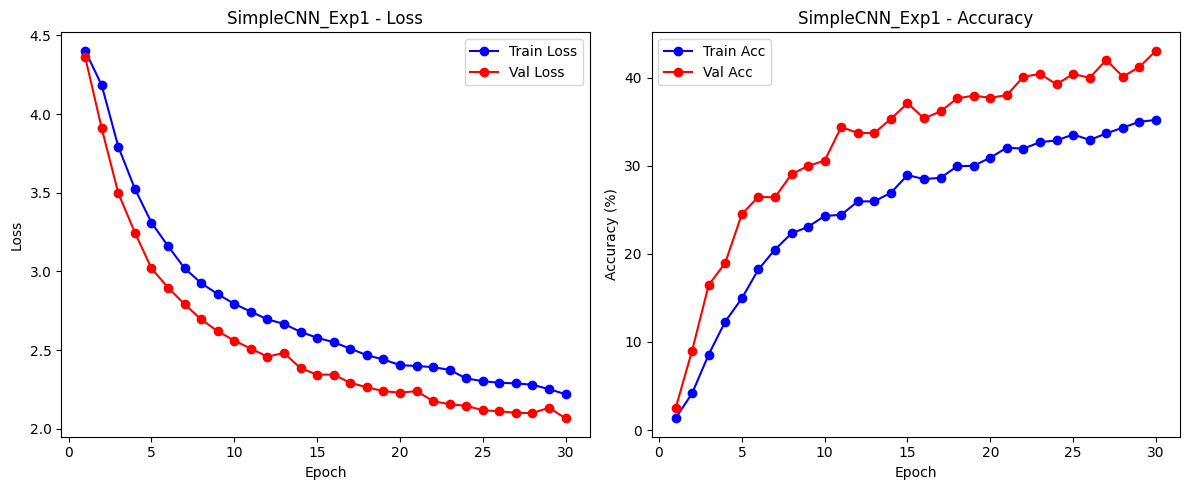


--- [SimpleCNN] Experiment 2 ---
Hyperparams: {'lr': 0.0005, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'Adam', 'weight_decay': 0.0001}
Epoch [1/30] | Train Loss: 4.4087, Acc: 1.50% | Val Loss: 4.4040, Acc: 1.78%
Epoch [2/30] | Train Loss: 4.3337, Acc: 2.49% | Val Loss: 4.1409, Acc: 4.48%
Epoch [3/30] | Train Loss: 4.0166, Acc: 5.31% | Val Loss: 3.7882, Acc: 9.46%
Epoch [4/30] | Train Loss: 3.7494, Acc: 8.46% | Val Loss: 3.5116, Acc: 15.11%
Epoch [5/30] | Train Loss: 3.5604, Acc: 11.07% | Val Loss: 3.3319, Acc: 16.65%
Epoch [6/30] | Train Loss: 3.3916, Acc: 12.62% | Val Loss: 3.1565, Acc: 19.04%
Epoch [7/30] | Train Loss: 3.2747, Acc: 14.89% | Val Loss: 3.0218, Acc: 21.50%
Epoch [8/30] | Train Loss: 3.1738, Acc: 16.96% | Val Loss: 2.9913, Acc: 24.75%
Epoch [9/30] | Train Loss: 3.0779, Acc: 18.52% | Val Loss: 2.8743, Acc: 24.51%
Epoch [10/30] | Train Loss: 2.9871, Acc: 20.52% | Val Loss: 2.7568, Acc: 27.33%
Epoch [11/30] | Train Loss: 2.9260, Acc: 20.93% | Val Loss: 2.6801, 

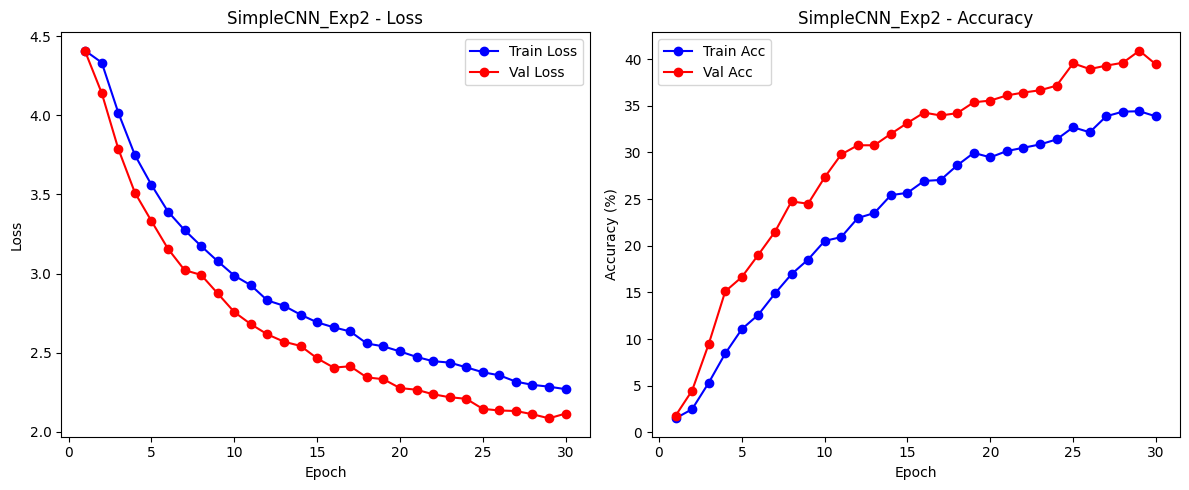


--- [SimpleCNN] Experiment 3 ---
Hyperparams: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'SGD', 'weight_decay': 0.0}
Epoch [1/30] | Train Loss: 4.4089, Acc: 1.03% | Val Loss: 4.4115, Acc: 0.61%
Epoch [2/30] | Train Loss: 4.4054, Acc: 1.47% | Val Loss: 4.4108, Acc: 1.11%
Epoch [3/30] | Train Loss: 4.4002, Acc: 2.13% | Val Loss: 4.4034, Acc: 2.40%
Epoch [4/30] | Train Loss: 4.3701, Acc: 2.53% | Val Loss: 4.3190, Acc: 3.07%
Epoch [5/30] | Train Loss: 4.1936, Acc: 3.67% | Val Loss: 3.9876, Acc: 6.27%
Epoch [6/30] | Train Loss: 3.9179, Acc: 6.86% | Val Loss: 3.6954, Acc: 8.91%
Epoch [7/30] | Train Loss: 3.7338, Acc: 7.93% | Val Loss: 3.4834, Acc: 11.61%
Epoch [8/30] | Train Loss: 3.5730, Acc: 10.83% | Val Loss: 3.3174, Acc: 14.43%
Epoch [9/30] | Train Loss: 3.3986, Acc: 13.32% | Val Loss: 3.1072, Acc: 18.00%
Epoch [10/30] | Train Loss: 3.2663, Acc: 15.15% | Val Loss: 3.0253, Acc: 18.92%
Epoch [11/30] | Train Loss: 3.1410, Acc: 17.17% | Val Loss: 2.7715, Acc: 24.63%


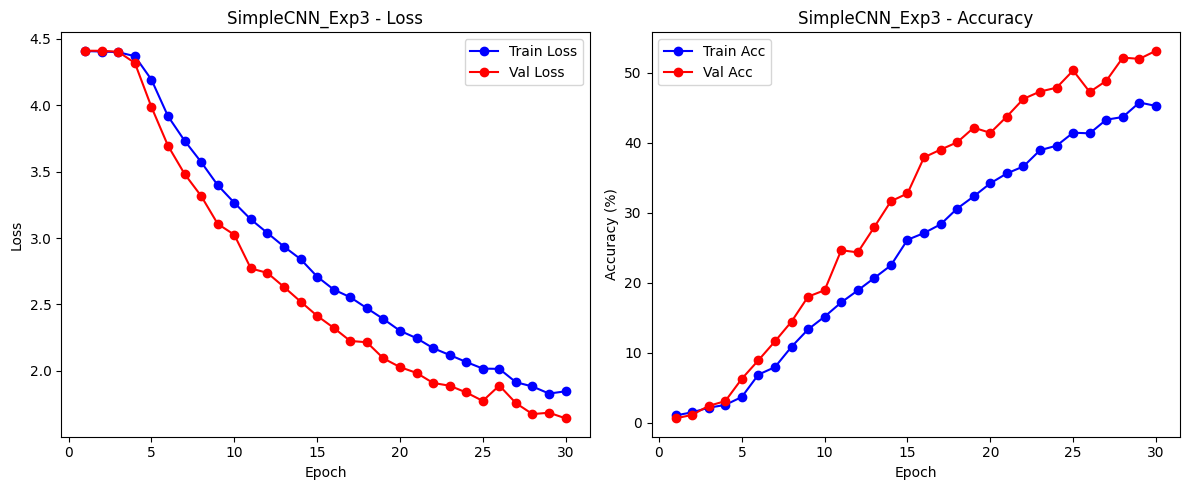


--- [DeeperCNN] Experiment 1 ---
Hyperparams: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'Adam', 'weight_decay': 0.0}
Epoch [1/30] | Train Loss: 4.4052, Acc: 1.21% | Val Loss: 4.3622, Acc: 1.41%
Epoch [2/30] | Train Loss: 4.0252, Acc: 6.51% | Val Loss: 3.6394, Acc: 12.47%
Epoch [3/30] | Train Loss: 3.4292, Acc: 14.49% | Val Loss: 3.2044, Acc: 18.30%
Epoch [4/30] | Train Loss: 3.0968, Acc: 18.48% | Val Loss: 2.9111, Acc: 22.30%
Epoch [5/30] | Train Loss: 2.8092, Acc: 24.74% | Val Loss: 2.6923, Acc: 25.55%
Epoch [6/30] | Train Loss: 2.6235, Acc: 27.50% | Val Loss: 2.5732, Acc: 29.24%
Epoch [7/30] | Train Loss: 2.4832, Acc: 30.94% | Val Loss: 2.4613, Acc: 32.92%
Epoch [8/30] | Train Loss: 2.3794, Acc: 33.32% | Val Loss: 2.3420, Acc: 34.58%
Epoch [9/30] | Train Loss: 2.2220, Acc: 36.80% | Val Loss: 2.2534, Acc: 36.55%
Epoch [10/30] | Train Loss: 2.1101, Acc: 38.92% | Val Loss: 2.1731, Acc: 38.45%
Epoch [11/30] | Train Loss: 2.0255, Acc: 40.72% | Val Loss: 2.0627, 

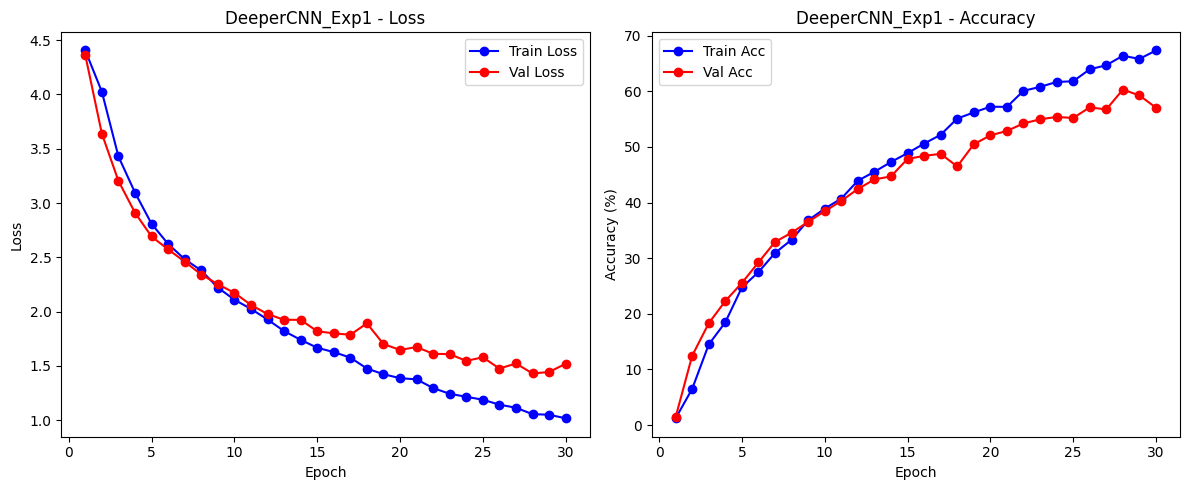


--- [DeeperCNN] Experiment 2 ---
Hyperparams: {'lr': 0.0005, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'Adam', 'weight_decay': 0.0001}
Epoch [1/30] | Train Loss: 4.3792, Acc: 1.70% | Val Loss: 4.1953, Acc: 6.08%
Epoch [2/30] | Train Loss: 3.8503, Acc: 8.15% | Val Loss: 3.5871, Acc: 12.47%
Epoch [3/30] | Train Loss: 3.4949, Acc: 12.65% | Val Loss: 3.3729, Acc: 16.77%
Epoch [4/30] | Train Loss: 3.3168, Acc: 15.70% | Val Loss: 3.2290, Acc: 18.12%
Epoch [5/30] | Train Loss: 3.1353, Acc: 18.03% | Val Loss: 3.0637, Acc: 21.62%
Epoch [6/30] | Train Loss: 2.9767, Acc: 21.24% | Val Loss: 2.9286, Acc: 22.60%
Epoch [7/30] | Train Loss: 2.8335, Acc: 23.56% | Val Loss: 2.7969, Acc: 26.29%
Epoch [8/30] | Train Loss: 2.7347, Acc: 24.98% | Val Loss: 2.7294, Acc: 27.21%
Epoch [9/30] | Train Loss: 2.6607, Acc: 27.06% | Val Loss: 2.6523, Acc: 29.79%
Epoch [10/30] | Train Loss: 2.5919, Acc: 28.04% | Val Loss: 2.6666, Acc: 27.83%
Epoch [11/30] | Train Loss: 2.5277, Acc: 29.45% | Val Loss: 2.58

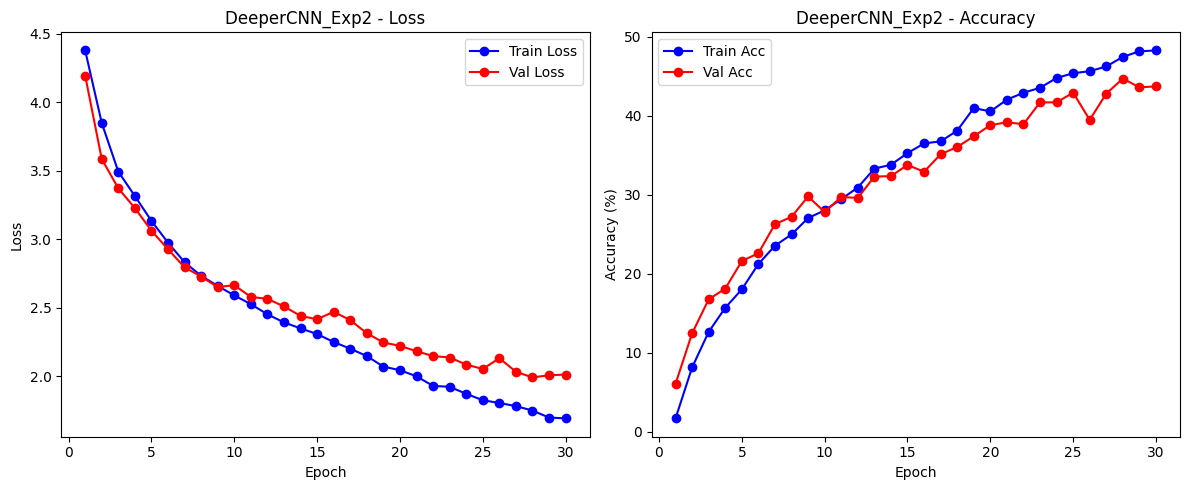


--- [DeeperCNN] Experiment 3 ---
Hyperparams: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 30, 'optimizer_name': 'SGD', 'weight_decay': 0.0}
Epoch [1/30] | Train Loss: 4.4092, Acc: 0.91% | Val Loss: 4.4109, Acc: 0.61%
Epoch [2/30] | Train Loss: 4.4071, Acc: 1.00% | Val Loss: 4.4130, Acc: 0.61%
Epoch [3/30] | Train Loss: 4.4061, Acc: 1.35% | Val Loss: 4.4141, Acc: 0.61%
Epoch [4/30] | Train Loss: 4.4056, Acc: 1.32% | Val Loss: 4.4152, Acc: 0.61%
Epoch [5/30] | Train Loss: 4.4051, Acc: 1.29% | Val Loss: 4.4176, Acc: 0.61%
Epoch [6/30] | Train Loss: 4.4047, Acc: 1.43% | Val Loss: 4.4151, Acc: 0.61%
Epoch [7/30] | Train Loss: 4.4031, Acc: 1.38% | Val Loss: 4.4131, Acc: 0.55%
Epoch [8/30] | Train Loss: 4.3967, Acc: 1.60% | Val Loss: 4.3984, Acc: 0.86%
Epoch [9/30] | Train Loss: 4.3086, Acc: 3.19% | Val Loss: 4.1712, Acc: 4.30%
Epoch [10/30] | Train Loss: 4.0543, Acc: 6.03% | Val Loss: 3.8394, Acc: 9.15%
Epoch [11/30] | Train Loss: 3.7130, Acc: 10.05% | Val Loss: 3.5821, Acc: 11.86%
Epoch [

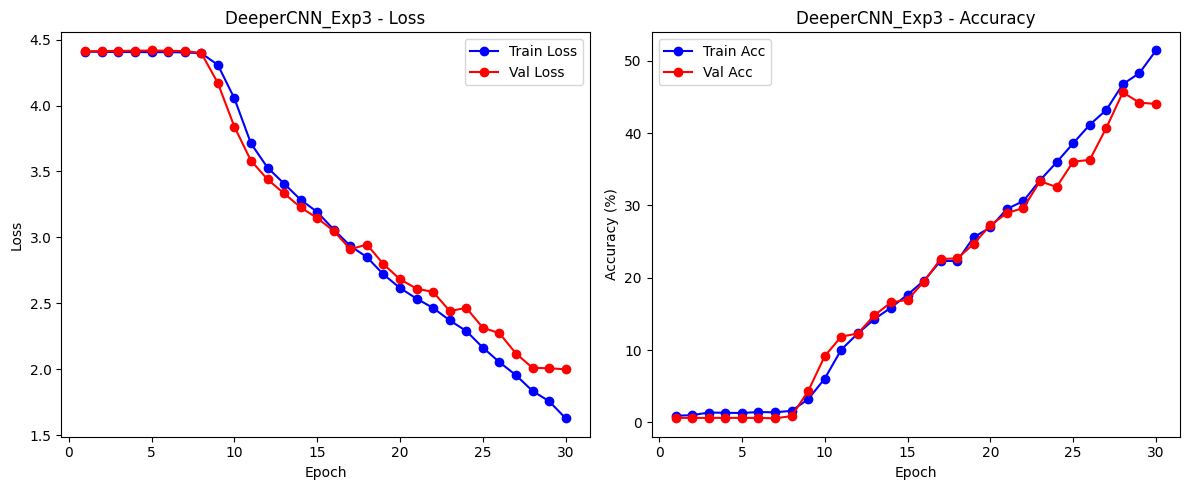


Training Completed.
Overall Best Model: DeeperCNN_Exp1_ValAcc60.32
Best Validation Accuracy: 60.32%
Best model saved to best_model_task1.h5!


In [ ]:
if __name__ == "__main__":
    # For reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Decide device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if device.type == "cuda":
        print("GPU Name:", torch.cuda.get_device_name(0))

    # We’ll test some hyperparams on both networks
    hyperparam_sets = [
        {"lr": 0.001, "batch_size": 32, "num_epochs": 30,  "optimizer_name": "Adam", "weight_decay": 0.0},
        {"lr": 0.0005,"batch_size": 32, "num_epochs": 30, "optimizer_name": "Adam", "weight_decay": 1e-4},
        {"lr": 0.01,  "batch_size": 32, "num_epochs": 30, "optimizer_name": "SGD",  "weight_decay": 0.0},
    ]

    # Load data once to determine num_classes:
    tmp_train_loader, tmp_val_loader, num_classes = get_data_loaders(
        data_dir="isolated_words_per_user",
        batch_size=32,
        val_ratio=0.2,
        width=256,
        height=128
    )
    print(f"Detected {num_classes} classes (users).")

    overall_best_acc = 0.0
    overall_best_model = None
    overall_best_title = ""

     # ---------------------- SimpleCNN Experiments ----------------------
    for i, hparams in enumerate(hyperparam_sets, start=1):
        # Refresh DataLoaders if batch_size changes
        train_loader, val_loader, _ = get_data_loaders(
            data_dir="isolated_words_per_user",
            batch_size=hparams["batch_size"],
            val_ratio=0.2,
            width=256,
            height=128
        )

        model = SimpleCNN(num_classes=num_classes).to(device)
        print(f"\n--- [SimpleCNN] Experiment {i} ---")
        print("Hyperparams:", hparams)

        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=hparams["num_epochs"],
            lr=hparams["lr"],
            optimizer_name=hparams["optimizer_name"],
            device=device,
            weight_decay=hparams["weight_decay"]
        )

        train_losses, val_losses, train_accs, val_accs = history
        best_val_acc = max(val_accs)

        plot_curves(train_losses, val_losses, train_accs, val_accs, title=f"SimpleCNN_Exp{i}")

        if best_val_acc > overall_best_acc:
            overall_best_acc = best_val_acc
            overall_best_model = model
            overall_best_title = f"SimpleCNN_Exp{i}_ValAcc{best_val_acc:.2f}"

     # ---------------------- DeeperCNN Experiments ----------------------
    for i, hparams in enumerate(hyperparam_sets, start=1):
        train_loader, val_loader, _ = get_data_loaders(
            data_dir="isolated_words_per_user",
            batch_size=hparams["batch_size"],
            val_ratio=0.2,
            width=256,
            height=128
        )

        model = DeeperCNN(num_classes=num_classes).to(device)
        print(f"\n--- [DeeperCNN] Experiment {i} ---")
        print("Hyperparams:", hparams)

        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=hparams["num_epochs"],
            lr=hparams["lr"],
            optimizer_name=hparams["optimizer_name"],
            device=device,
            weight_decay=hparams["weight_decay"]
        )

        train_losses, val_losses, train_accs, val_accs = history
        best_val_acc = max(val_accs)

        plot_curves(train_losses, val_losses, train_accs, val_accs, title=f"DeeperCNN_Exp{i}")

        if best_val_acc > overall_best_acc:
            overall_best_acc = best_val_acc
            overall_best_model = model
            overall_best_title = f"DeeperCNN_Exp{i}_ValAcc{best_val_acc:.2f}"

    # Show overall best
    print("\nTraining Completed.")
    print(f"Overall Best Model: {overall_best_title}")
    print(f"Best Validation Accuracy: {overall_best_acc:.2f}%")

    # Save the best model
    if overall_best_model:
        save_model_h5(overall_best_model, filename="best_model_task1.h5")
        print("Best model saved to best_model_task1.h5!")
    else:
        print("No best model found (unexpected).")

#**Task2: Retrain the Network Selected from Task 1 after Doing Data Augmentation**

In this task, we will:
1. Generate an augmented dataset physically in a new folder (`isolated_words_per_user_aug/`).
2. Define our custom dataset that points to the augmented folder.
3. Train the same `DeeperCNN` architecture from Task 1 **from scratch** on the augmented dataset.
4. Compare our results (loss & accuracy) to those from Task 1.

## Unzip Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

##  Data Augmentation Functions


In [ ]:
import os
import glob
import cv2
import random
import numpy as np
from PIL import Image

def apply_random_augmentations(img):
    #Applies random transformations (flip, rotation) to a grayscale image.
    pil_img = Image.fromarray(img)  # Convert to PIL

    # 1. Random horizontal flip (50% chance)
    if random.random() < 0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)

    # 2. Random rotation (±15 degrees)
    angle = random.uniform(-15, 15)
    pil_img = pil_img.rotate(angle, fillcolor=0)  # fill corners with black=0

    # Convert back to NumPy array
    aug_img = np.array(pil_img)
    return aug_img


def augment_and_save_dataset(
    src_root="isolated_words_per_user",
    dst_root="isolated_words_per_user_aug",
    num_augment_per_image=1,
    random_seed=42
):
    """
    Copies images from src_root, and for each one,
    creates 'num_augment_per_image' extra augmented images
    in the new folder dst_root.
    """
    random.seed(random_seed)

    # Create the destination directory
    if not os.path.exists(dst_root):
        os.makedirs(dst_root)

    # Collect user subfolders
    users = sorted([d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root, d))])

    for user in users:
        src_user_dir = os.path.join(src_root, user)
        dst_user_dir = os.path.join(dst_root, user)
        if not os.path.exists(dst_user_dir):
            os.makedirs(dst_user_dir)

        # For each image in the user's folder
        image_paths = glob.glob(os.path.join(src_user_dir, '*.*'))
        for img_path in image_paths:
            # Copy original image
            img_name = os.path.basename(img_path)
            dst_path_original = os.path.join(dst_user_dir, img_name)
            if not os.path.exists(dst_path_original):
                with open(img_path, 'rb') as fsrc, open(dst_path_original, 'wb') as fdst:
                    fdst.write(fsrc.read())

            # Load the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to read {img_path}, skipping.")
                continue

            # Create augmented images
            for aug_i in range(num_augment_per_image):
                aug_img = apply_random_augmentations(img)
                base, ext = os.path.splitext(img_name)
                aug_name = f"{base}_aug{aug_i}{ext}"
                dst_path_aug = os.path.join(dst_user_dir, aug_name)
                cv2.imwrite(dst_path_aug, aug_img)

## Create Augmented Dataset

In [ ]:
# For each original image, create 2 augmented versions
augment_and_save_dataset(
    src_root="isolated_words_per_user",      # folder with original data
    dst_root="isolated_words_per_user_aug",  # new folder to contain original + augmented
    num_augment_per_image=2,
    random_seed=42
)

print("Augmented dataset created at 'isolated_words_per_user_aug'!")

Augmented dataset created at 'isolated_words_per_user_aug'!


## Custom Dataset (Pointing to the augmented folder)

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

class ArabicHandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None, width=256, height=128):
        self.root_dir = root_dir
        self.transform = transform
        self.width = width
        self.height = height

        self.image_paths = []
        self.labels = []

        # Each folder inside root_dir is one user
        self.users = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.user_to_label = {user: idx for idx, user in enumerate(self.users)}

        for user in self.users:
            user_folder = os.path.join(root_dir, user)
            for img_path in glob.glob(os.path.join(user_folder, '*.*')):
                self.image_paths.append(img_path)
                self.labels.append(self.user_to_label[user])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to read image: {img_path}")

        # Resize => (width=256, height=128)
        img = cv2.resize(img, (self.width, self.height))

        # Convert to tensor [1, H, W], scale to [0,1]
        img_tensor = torch.from_numpy(img).unsqueeze(0).float() / 255.0

        # If there's any transform pipeline, apply here
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

def get_data_loaders(
    data_dir="isolated_words_per_user_aug",  # **Augmented** dataset folder
    batch_size=32,
    val_ratio=0.2,
    shuffle=True,
    width=256,
    height=128
):
    dataset = ArabicHandwritingDataset(root_dir=data_dir, width=width, height=height)
    num_classes = len(dataset.users)

    # Train/Val split
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, num_classes

## Define DeeperCNN Architecture

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=82, dropout_p=0.2):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

        # We'll do 3 pools => shape is ~ (128 * 4 * 4) after adaptive pooling:
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training, Plotting, and Saving Utilities

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=0.001,
    optimizer_name="Adam",
    device="cpu",
    weight_decay=0.0
):
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = 100.0 * correct / total

        # Validation
        model.eval()
        running_loss_val, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_loss_val / total_val
        epoch_val_acc = 100.0 * correct_val / total_val

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

        # Track best
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict()

    # Load best
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, (train_losses, val_losses, train_accs, val_accs)


def plot_curves(train_losses, val_losses, train_accs, val_accs, title="DeeperCNN_OfflineAug_Task2"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, 'b-o', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-o', label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def save_model_h5(model, filename="best_model_task2_aug.h5"):
    state_dict = model.state_dict()
    with h5py.File(filename, 'w') as h5f:
        for layer_name, weights in state_dict.items():
            h5f.create_dataset(layer_name, data=weights.cpu().numpy())

## Main Execution

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Number of classes (users): 82
Epoch [1/30] | Train Loss: 4.0513, Acc: 4.84% | Val Loss: 3.4520, Acc: 11.17%
Epoch [2/30] | Train Loss: 3.1886, Acc: 16.29% | Val Loss: 2.9560, Acc: 20.16%
Epoch [3/30] | Train Loss: 2.6191, Acc: 27.34% | Val Loss: 2.5595, Acc: 28.10%
Epoch [4/30] | Train Loss: 2.2740, Acc: 34.45% | Val Loss: 2.2166, Acc: 36.53%
Epoch [5/30] | Train Loss: 2.0309, Acc: 40.11% | Val Loss: 2.0382, Acc: 39.71%
Epoch [6/30] | Train Loss: 1.8583, Acc: 43.76% | Val Loss: 1.9733, Acc: 42.04%
Epoch [7/30] | Train Loss: 1.7026, Acc: 48.28% | Val Loss: 1.8209, Acc: 45.44%
Epoch [8/30] | Train Loss: 1.5713, Acc: 51.20% | Val Loss: 1.7176, Acc: 48.32%
Epoch [9/30] | Train Loss: 1.4566, Acc: 55.32% | Val Loss: 1.6609, Acc: 50.49%
Epoch [10/30] | Train Loss: 1.3474, Acc: 57.66% | Val Loss: 1.6378, Acc: 51.58%
Epoch [11/30] | Train Loss: 1.2570, Acc: 60.81% | Val Loss: 1.5410, Acc: 53.56%
Epoch [12/30] | Train Loss: 1.1783, Acc: 62.92% | Val 

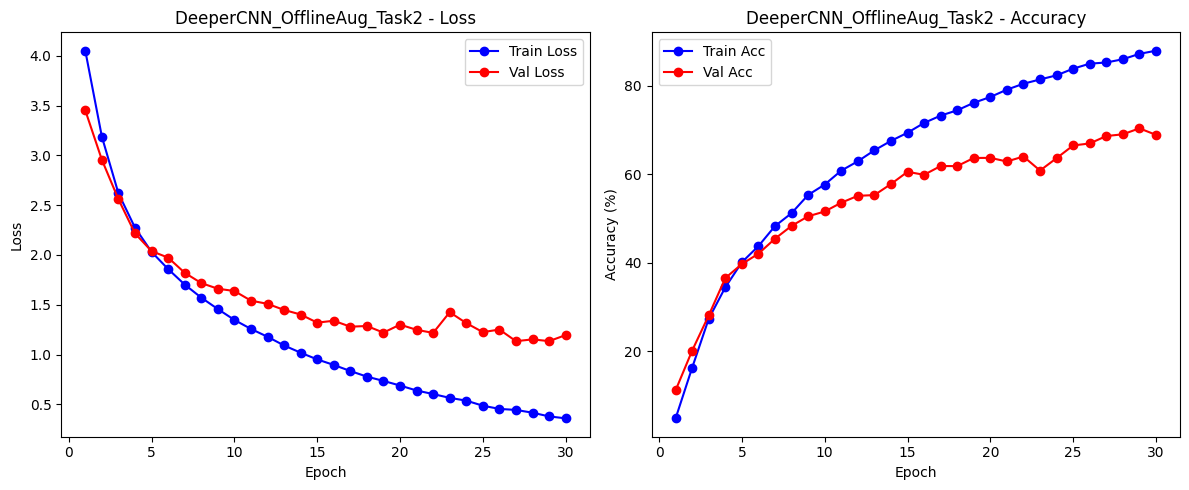

Retrained model (from scratch) saved to best_model_task2_aug.h5!


In [ ]:
if __name__ == "__main__":
    # For reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if device.type == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))

    # Load the augmented dataset
    train_loader, val_loader, num_classes = get_data_loaders(
        data_dir="isolated_words_per_user_aug",  # The new augmented folder
        batch_size=32,
        val_ratio=0.2,
        width=256,
        height=128
    )

    print(f"Number of classes (users): {num_classes}")

    # Initialize DeeperCNN from scratch
    model = DeeperCNN(num_classes=num_classes, dropout_p=0.0).to(device)

    # Use best hyperparams discovered in Task 1
    best_hparams = {
        "lr": 0.001,
        "batch_size": 32,
        "num_epochs": 30,
        "optimizer_name": "Adam",
        "weight_decay": 0.0
    }

    # Train from scratch on augmented data
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=best_hparams["num_epochs"],
        lr=best_hparams["lr"],
        optimizer_name=best_hparams["optimizer_name"],
        device=device,
        weight_decay=best_hparams["weight_decay"]
    )

    train_losses, val_losses, train_accs, val_accs = history

    # Print the highest validation accuracy
    max_val_acc = max(val_accs)
    print(f"Highest Validation Accuracy over 30 epochs: {max_val_acc:.2f}%")

    # Plot
    plot_curves(train_losses, val_losses, train_accs, val_accs, title="DeeperCNN_OfflineAug_Task2")

    # Save the new Task 2 model
    save_model_h5(model, filename="best_model_task2_aug.h5")
    print("Retrained model (from scratch) saved to best_model_task2_aug.h5!")

## Convert an Aug data into a Zip File

In [ ]:
import shutil
import os

# Original folder to zip
folder_to_zip = "isolated_words_per_user_aug"

# Create a parent directory to add an extra level
parent_folder = "parent_folder"
os.makedirs(parent_folder, exist_ok=True)

# Copy the target folder into the parent directory
shutil.copytree(folder_to_zip, os.path.join(parent_folder, folder_to_zip))

# Create the zip file from the parent directory
output_zip_file = "isolated_words_per_user_aug.zip"
shutil.make_archive(base_name=output_zip_file.replace('.zip', ''), format='zip', root_dir=parent_folder)

# Cleanup: Remove the parent directory
shutil.rmtree(parent_folder)

print(f"Folder '{folder_to_zip}' has been successfully zipped into '{output_zip_file}' with an additional directory level.")

Folder 'isolated_words_per_user_aug' has been successfully zipped into 'isolated_words_per_user_aug.zip' with an additional directory level.


## Comparison between Task1 and Task2

The comparison between Task 1 (DeeperCNN without Data Augmentation) and Task 2 (DeeperCNN with Data Augmentation) showed the big effect of data augmentation on model performance. In Task 1, the model had a training loss of 1.0563 and a validation loss of 1.4310. Training accuracy was 66.41%, and validation accuracy was 60.32%.

In Task 2, the results were much better. The training loss was reduced to 0.3784, and the validation loss dropped to 1.1345. Training accuracy improved to 87.19%, and validation accuracy increased to 70.36%.

The better performance in Task 2 was because data augmentation was used. Augmentation added variations to the dataset, so the model learned to generalize better. The smaller gap between training and validation accuracies in Task 2 showed the model became more robust. Also, the loss curves in Task 2 were smoother and closer, meaning overfitting was reduced.

In summary, Task 2 showed that using data augmentation helped the model learn from diverse data and improved both training and validation results.


#**Task3: AlexNet from Scratch with Improved Setup**

## Unzip Aug Data and Import Laibraries

In [ ]:
import zipfile
with zipfile.ZipFile('isolated_words_per_user_aug.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision import models

## Custom Dataset

In [ ]:
class ArabicHandwritingDataset(Dataset):
    """
    Loads images from 'root_dir', each subfolder => 1 user/class.
    Applies transformations directly to PIL Images.
    """
    def __init__(self, root_dir, transform=None, img_size=224):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        self.image_paths = []
        self.labels = []

        # Each subfolder => 1 user => 1 label (class)
        self.users = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.user_to_label = {user: idx for idx, user in enumerate(self.users)}

        # Gather images
        for user in self.users:
            user_folder = os.path.join(root_dir, user)
            for img_file in glob.glob(os.path.join(user_folder, '*.*')):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.image_paths.append(img_file)
                    self.labels.append(self.user_to_label[user])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image as PIL Image
        try:
            image = Image.open(img_path).convert('RGB')
            image = image.resize((self.img_size, self.img_size))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image and a dummy label
            image = Image.new('RGB', (self.img_size, self.img_size))
            label = 0

        if self.transform:
            image = self.transform(image)

        return image, label

## DataLoaders

In [ ]:
def get_data_loaders_updated(
    data_dir="isolated_words_per_user_aug",
    batch_size=32,
    val_ratio=0.2,
    shuffle=True,
    img_size=224
):
    """
    Creates DataLoaders with proper transformations.
    """
    # Define transformations for training and validation
    transform_train = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10, fill=0),
        T.ToTensor(),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])

    transform_val = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])

    # Initialize the dataset with no transforms
    full_dataset = ArabicHandwritingDataset(
        root_dir=data_dir,
        transform=None,
        img_size=img_size
    )
    num_classes = len(full_dataset.users)
    print(f"Number of classes: {num_classes}")

    # Split the dataset
    val_size = int(len(full_dataset) * val_ratio)
    train_size = len(full_dataset) - val_size
    train_ds, val_ds = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Assign transforms
    train_ds.dataset.transform = transform_train
    val_ds.dataset.transform = transform_val

    # Create DataLoaders
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
    )

    return train_loader, val_loader, num_classes

class TransformDataset(Dataset):
    """
    A wrapper that applies a specific transform to each sample from an existing dataset.
    Not needed if transforms are directly assigned to the Dataset after splitting.
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

## Build AlexNet from Scratch

In [ ]:
def build_alexnet(num_classes=82):
    # Initializes AlexNet without pretrained weights and modifies the final layer.
    model = models.alexnet(weights=None)
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

## Debug Print Function

In [ ]:
def debug_print_val_samples(val_loader, device, num_samples=5):
    # Print a small batch from val set to confirm shape & labels.
    print("\n--- Debug: Checking some validation samples ---")
    val_iter = iter(val_loader)
    images, labels = next(val_iter)
    images, labels = images.to(device), labels.to(device)
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")
    print(f"Sample labels: {labels[:num_samples].tolist()}")

## Training, Plotting, and Saving Utilities

In [ ]:
## Training & Plot

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=0.0005,
    optimizer_name="Adam",
    device="cpu",
    weight_decay=0.0,
    use_scheduler=True
):

    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()

    # Use a CosineAnnealingLR scheduler
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0
    best_model_state = None

    debug_print_val_samples(val_loader, device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = 100.0 * correct / total

        # Validation
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = 100.0 * correct_val / total_val

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

        # Track best
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict()

        if scheduler:
            scheduler.step()

    # Load best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

    return model, history

def plot_curves(train_losses, val_losses, train_accs, val_accs, title="AlexNet_Improved_Task3"):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, 'b-o', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-o', label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

def save_model_h5(model, filename="best_model_task3_alexnet_improved.h5"):
    state_dict = model.state_dict()
    import h5py
    with h5py.File(filename, 'w') as h5f:
        for layer_name, weights in state_dict.items():
            h5f.create_dataset(layer_name, data=weights.cpu().numpy())

## Main Execution

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Number of classes: 82
Number of classes (users): 82

--- Debug: Checking some validation samples ---
Batch shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Sample labels: [6, 16, 76, 38, 70]
Epoch [1/30] | Train Loss: 4.4079, Acc: 1.22% | Val Loss: 4.4108, Acc: 1.11%
Epoch [2/30] | Train Loss: 3.7416, Acc: 6.64% | Val Loss: 3.2871, Acc: 13.20%
Epoch [3/30] | Train Loss: 3.1415, Acc: 15.16% | Val Loss: 3.0357, Acc: 17.27%
Epoch [4/30] | Train Loss: 2.7644, Acc: 22.64% | Val Loss: 2.5413, Acc: 27.10%
Epoch [5/30] | Train Loss: 2.3481, Acc: 31.66% | Val Loss: 2.2247, Acc: 35.37%
Epoch [6/30] | Train Loss: 1.9856, Acc: 40.84% | Val Loss: 1.9069, Acc: 44.02%
Epoch [7/30] | Train Loss: 1.6427, Acc: 50.10% | Val Loss: 1.6985, Acc: 49.77%
Epoch [8/30] | Train Loss: 1.3224, Acc: 59.03% | Val Loss: 1.5433, Acc: 54.69%
Epoch [9/30] | Train Loss: 1.0497, Acc: 67.23% | Val Loss: 1.3449, Acc: 59.99%
Epoch [10/30] | Train Loss: 0.8218,

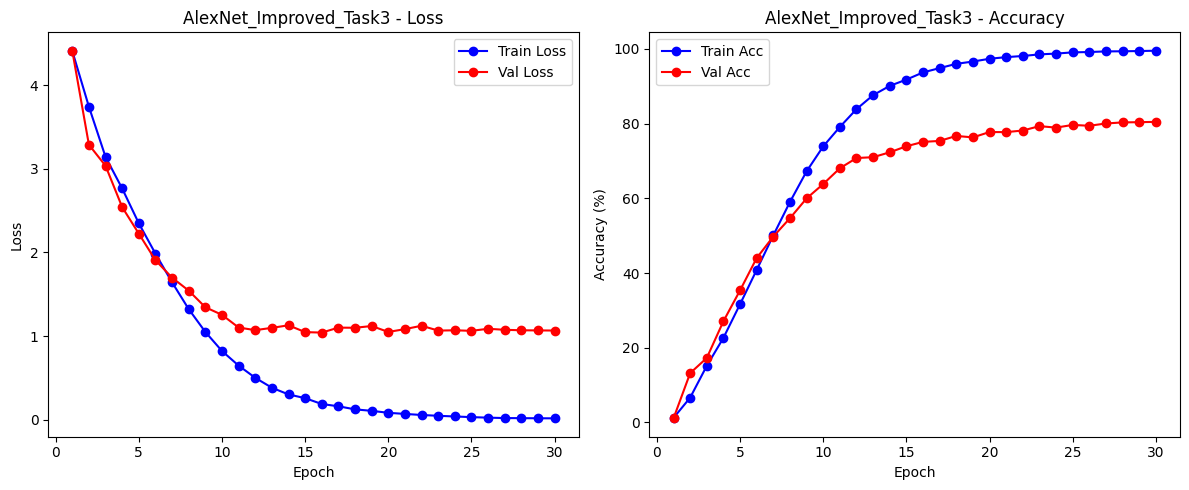

Model saved to best_model_task3_alexnet_improved.h5!


In [ ]:
if __name__ == "__main__":
    import random

    # For reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if device.type == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))

    # DataLoaders: updated with proper transforms
    train_loader, val_loader, num_classes = get_data_loaders_updated(
        data_dir="isolated_words_per_user_aug",
        batch_size=32,
        val_ratio=0.2,
        img_size=224
    )
    print(f"Number of classes (users): {num_classes}")

    # Build improved AlexNet from scratch
    model = build_alexnet(num_classes=num_classes).to(device)

    # Adjust hyperparams for better stability
    best_hparams = {
        "lr": 0.0005,
        "batch_size": 32,
        "num_epochs": 30,
        "optimizer_name": "Adam",
        "weight_decay": 0.0
    }

    # Train
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=best_hparams["num_epochs"],
        lr=best_hparams["lr"],
        optimizer_name=best_hparams["optimizer_name"],
        device=device,
        weight_decay=best_hparams["weight_decay"],
        use_scheduler=True
    )


    train_losses, val_losses, train_accs, val_accs = history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc']

    # Print the highest validation accuracy
    max_val_acc = max(val_accs)
    print(f"Highest Validation Accuracy over 30 epochs: {max_val_acc:.2f}%")

    # Plot
    plot_curves(train_losses, val_losses, train_accs, val_accs,
                title="AlexNet_Improved_Task3")

    # Save final model
    save_model_h5(model, filename="best_model_task3_alexnet_improved.h5")
    print("Model saved to best_model_task3_alexnet_improved.h5!")

## Comparison between Task2 and Task3

In Task 2, the DeeperCNN model with data augmentation showed strong performance. Training accuracy reached 87.19%, and validation accuracy was 70.36%. The training loss was reduced to 0.3784, and validation loss became stable at 1.1345. This showed good generalization on unseen data. The training and validation curves followed same trends, which meant the model was well-regularized with little overfitting.

But in Task 3, AlexNet did better. Training accuracy was 99.52%, and validation accuracy was 80.47%. The training loss was reduced a lot to 0.0169, and validation loss dropped to 1.0663. This improvement showed AlexNet could find more complex features because of its better architecture. The training and validation curves for AlexNet were smoother and closer, showing better stability and generalization than DeeperCNN.

In total, AlexNet performed much better than DeeperCNN, with 10.11% higher validation accuracy. It learned more efficiently and was a better choice for this dataset and task.


#**Task4: Pre-trained CNN Network and Transfer Learning**

## Unzip Aug Data

In [ ]:
import zipfile
with zipfile.ZipFile('isolated_words_per_user_aug.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Import Libraries and Utility Functions

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## Custom Dataset and  Data Augmentation

In [ ]:
class ArabicHandwritingDataset(Dataset):
    """
    Custom Dataset for Arabic Handwriting Images.
    Converts grayscale images to 3 channels for pre-trained models.
    """
    def __init__(self, root_dir, transform=None, img_size=224):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size
        self.image_paths = []
        self.labels = []
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for img_file in os.listdir(cls_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.image_paths.append(os.path.join(cls_folder, img_file))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB
        if self.transform:
            image = self.transform(image)
        return image, label


# Define Data Augmentation and Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_data_loaders(data_dir="isolated_words_per_user_aug", batch_size=32, val_ratio=0.2, shuffle=True, img_size=224):

    # Creates DataLoaders for training and validation datasets.
    full_dataset = ArabicHandwritingDataset(root_dir=data_dir, transform=None, img_size=img_size)
    num_classes = len(full_dataset.classes)
    print(f"Number of classes: {num_classes}")
    val_size = int(len(full_dataset) * val_ratio)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    train_dataset.dataset.transform = train_transforms
    val_dataset.dataset.transform = val_transforms
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, num_classes

## Define Model and Training Functions

In [ ]:
def build_resnet50(num_classes=82, pretrained=True, fine_tune=True):
    # Builds a ResNet50 model for transfer learning.
    model = models.resnet50(pretrained=pretrained)
    if not fine_tune:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Define Training Function
def train_model_transfer(model, train_loader, val_loader, num_epochs=15, learning_rate=1e-4, optimizer_name="Adam",
                         device="cuda" if torch.cuda.is_available() else "cpu", weight_decay=1e-4, scheduler_step_size=7,
                         scheduler_gamma=0.1, early_stopping_patience=5):

    # Trains the model with transfer learning, includes scheduler and early stopping.
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_acc = 0.0
    best_model_wts = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            dataloader = train_loader if phase == 'train' else val_loader
            running_loss, running_corrects, total_samples = 0.0, 0, 0
            for inputs, labels in tqdm(dataloader, desc=f"{phase} Epoch {epoch + 1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples * 100
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                scheduler.step()
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered!")
            break

    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accuracies,
                   'val_acc': val_accuracies}, best_val_acc.item()

## Plotting and Evaluation

In [ ]:
def plot_metrics(history, title="TransferLearning_Task4"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-o', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

## Main Execution

Number of classes: 82


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

val Epoch 1/15: 100%|██████████| 153/153 [00:03<00:00, 41.42it/s]


Train Loss: 1.7440 | Train Acc: 56.93%
Val Loss: 1.7397 | Val Acc: 52.74%

Epoch 2/15


val Epoch 2/15: 100%|██████████| 153/153 [00:03<00:00, 48.25it/s]


Train Loss: 0.3496 | Train Acc: 91.27%
Val Loss: 0.3120 | Val Acc: 91.10%

Epoch 3/15


val Epoch 3/15: 100%|██████████| 153/153 [00:03<00:00, 46.77it/s]


Train Loss: 0.1408 | Train Acc: 96.68%
Val Loss: 1.4747 | Val Acc: 62.85%

Epoch 4/15


val Epoch 4/15: 100%|██████████| 153/153 [00:03<00:00, 47.98it/s]


Train Loss: 0.1009 | Train Acc: 97.49%
Val Loss: 1.4188 | Val Acc: 65.62%

Epoch 5/15


val Epoch 5/15: 100%|██████████| 153/153 [00:03<00:00, 46.85it/s]


Train Loss: 0.0946 | Train Acc: 97.57%
Val Loss: 0.8856 | Val Acc: 74.19%

Epoch 6/15


val Epoch 6/15: 100%|██████████| 153/153 [00:03<00:00, 43.80it/s]


Train Loss: 0.0673 | Train Acc: 98.23%
Val Loss: 1.7793 | Val Acc: 59.23%

Epoch 7/15


val Epoch 7/15: 100%|██████████| 153/153 [00:03<00:00, 48.06it/s]


Train Loss: 0.0722 | Train Acc: 98.05%
Val Loss: 0.6054 | Val Acc: 83.38%

Epoch 8/15


val Epoch 8/15: 100%|██████████| 153/153 [00:03<00:00, 47.89it/s]


Train Loss: 0.0215 | Train Acc: 99.60%
Val Loss: 0.0352 | Val Acc: 99.22%

Epoch 9/15


val Epoch 9/15: 100%|██████████| 153/153 [00:03<00:00, 49.35it/s]


Train Loss: 0.0068 | Train Acc: 99.94%
Val Loss: 0.0271 | Val Acc: 99.28%

Epoch 10/15


val Epoch 10/15: 100%|██████████| 153/153 [00:03<00:00, 48.28it/s]


Train Loss: 0.0053 | Train Acc: 99.96%
Val Loss: 0.0257 | Val Acc: 99.30%

Epoch 11/15


val Epoch 11/15: 100%|██████████| 153/153 [00:03<00:00, 44.39it/s]


Train Loss: 0.0039 | Train Acc: 99.97%
Val Loss: 0.0232 | Val Acc: 99.45%

Epoch 12/15


val Epoch 12/15: 100%|██████████| 153/153 [00:03<00:00, 47.12it/s]


Train Loss: 0.0039 | Train Acc: 99.98%
Val Loss: 0.0219 | Val Acc: 99.47%

Epoch 13/15


val Epoch 13/15: 100%|██████████| 153/153 [00:03<00:00, 44.16it/s]


Train Loss: 0.0026 | Train Acc: 99.99%
Val Loss: 0.0195 | Val Acc: 99.51%

Epoch 14/15


val Epoch 14/15: 100%|██████████| 153/153 [00:03<00:00, 47.44it/s]


Train Loss: 0.0022 | Train Acc: 100.00%
Val Loss: 0.0187 | Val Acc: 99.51%

Epoch 15/15


val Epoch 15/15: 100%|██████████| 153/153 [00:03<00:00, 48.18it/s]


Train Loss: 0.0018 | Train Acc: 100.00%
Val Loss: 0.0177 | Val Acc: 99.53%


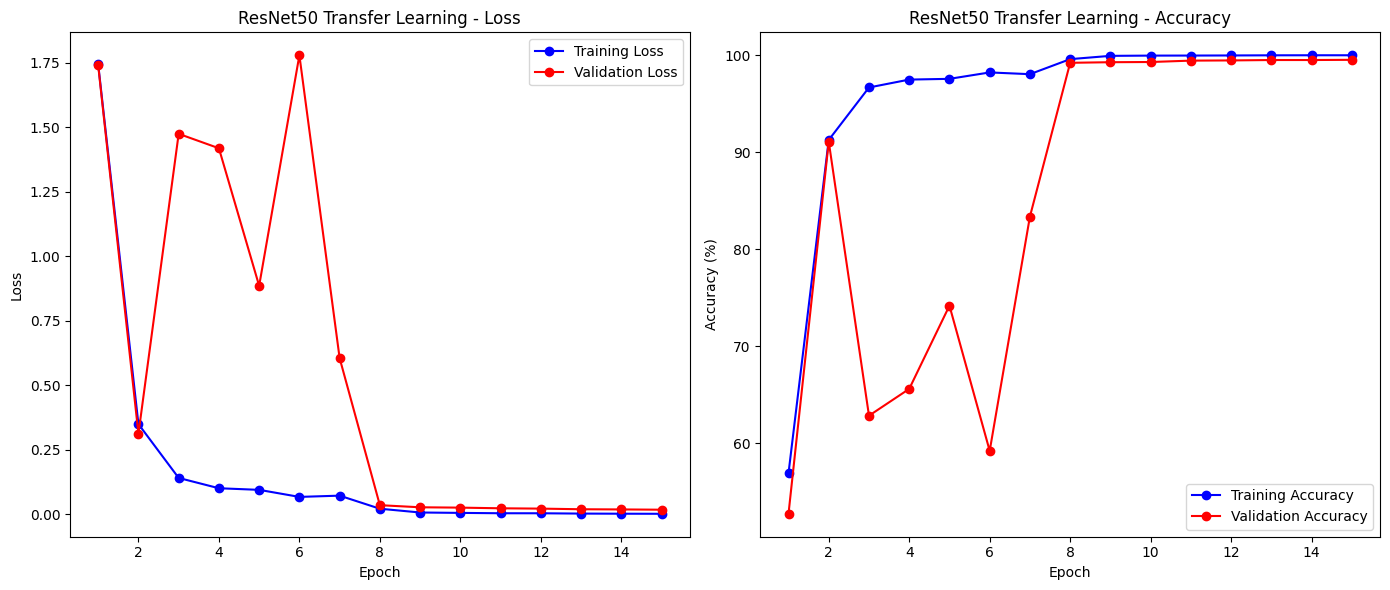

Model saved! Best Validation Accuracy: 99.53%


In [ ]:
if __name__ == "__main__":
    data_dir = "isolated_words_per_user_aug"
    batch_size = 32
    num_epochs = 15
    learning_rate = 1e-4
    optimizer_name = "Adam"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load Data
    train_loader, val_loader, num_classes = get_data_loaders(data_dir, batch_size)

    # Build and Train Model
    model = build_resnet50(num_classes=num_classes, pretrained=True, fine_tune=True).to(device)
    print(model)
    trained_model, history, best_val_accuracy = train_model_transfer(
        model, train_loader, val_loader, num_epochs, learning_rate, optimizer_name, device, weight_decay=1e-4,
        scheduler_step_size=7, scheduler_gamma=0.1, early_stopping_patience=7)
    # Plot Metrics
    plot_metrics(history, title="ResNet50 Transfer Learning")

    # Save Model
    torch.save(trained_model.state_dict(), "best_model_task4_resnet50.pth")
    print(f"Model saved! Best Validation Accuracy: {best_val_accuracy:.2f}%")

## Comparison between Task3 and Task4

The comparison between Task 3 (AlexNet) and Task 4 (ResNet50 with Transfer Learning) showed big differences in training speed, accuracy, and performance on validation data. In Task 3, AlexNet was trained from scratch with better settings. The training loss was 0.0169 and the validation loss was 1.0663. The training accuracy reached 99.52%, but the validation accuracy was 80.47%. This showed that the model worked well, but there was still a gap between training and validation. The learning curves showed a steady decrease in training and validation loss over 30 epochs, showing good progress and optimization. However, the higher validation loss suggested that the model could be better at handling new data.

In Task 4, ResNet50 with transfer learning was used, and it performed better. The training loss was 0.0018 and the validation loss was 0.0177. The training accuracy reached 100%, and the validation accuracy improved to 99.53%. The pre-trained weights and fine-tuning allowed faster training and better generalization, seen in how quickly the training and validation metrics stabilized in just 15 epochs. The loss and accuracy curves showed steady performance, with very little difference between training and validation, showing that ResNet50 was better at capturing complex patterns in the data. Overall, Task 4 did better than Task 3 in both accuracy and speed, showing that transfer learning works better than training from scratch, especially for complex models and big datasets.
